In [5]:
import os 
try:
    os.chdir('sliders')
except:
    pass
import torch
from PIL import Image
import argparse
import os, json, random
import pandas as pd
import matplotlib.pyplot as plt
import glob, re

from safetensors.torch import load_file
import matplotlib.image as mpimg
import copy
import gc
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import DiffusionPipeline
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor, AttentionProcessor
from typing import Any, Dict, List, Optional, Tuple, Union
from trainscripts.textsliders.lora import LoRANetwork, DEFAULT_TARGET_REPLACE, UNET_TARGET_REPLACE_MODULE_CONV
from diffusers.pipelines.stable_diffusion_xl import StableDiffusionXLPipelineOutput

In [6]:
import inspect
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from diffusers.pipelines import StableDiffusionXLPipeline
import random

import torch
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    
@torch.no_grad()
def call(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
    
        network=None, 
        start_noise=None,
        scale=None,
        unet=None,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in both text-encoders
            height (`int`, *optional*, defaults to unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image. This is set to 1024 by default for the best results.
                Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            width (`int`, *optional*, defaults to unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image. This is set to 1024 by default for the best results.
                Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            denoising_end (`float`, *optional*):
                When specified, determines the fraction (between 0.0 and 1.0) of the total denoising process to be
                completed before it is intentionally prematurely terminated. As a result, the returned sample will
                still retain a substantial amount of noise as determined by the discrete timesteps selected by the
                scheduler. The denoising_end parameter should ideally be utilized when this pipeline forms a part of a
                "Mixture of Denoisers" multi-pipeline setup, as elaborated in [**Refining the Image
                Output**](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl#refining-the-image-output)
            guidance_scale (`float`, *optional*, defaults to 5.0):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
                `text_encoder_2`. If not defined, `negative_prompt` is used in both text-encoders
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
                input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] instead
                of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            guidance_rescale (`float`, *optional*, defaults to 0.7):
                Guidance rescale factor proposed by [Common Diffusion Noise Schedules and Sample Steps are
                Flawed](https://arxiv.org/pdf/2305.08891.pdf) `guidance_scale` is defined as `φ` in equation 16. of
                [Common Diffusion Noise Schedules and Sample Steps are Flawed](https://arxiv.org/pdf/2305.08891.pdf).
                Guidance rescale factor should fix overexposure when using zero terminal SNR.
            original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                If `original_size` is not the same as `target_size` the image will appear to be down- or upsampled.
                `original_size` defaults to `(width, height)` if not specified. Part of SDXL's micro-conditioning as
                explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                `crops_coords_top_left` can be used to generate an image that appears to be "cropped" from the position
                `crops_coords_top_left` downwards. Favorable, well-centered images are usually achieved by setting
                `crops_coords_top_left` to (0, 0). Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                For most cases, `target_size` should be set to the desired height and width of the generated image. If
                not specified it will default to `(width, height)`. Part of SDXL's micro-conditioning as explained in
                section 2.2 of [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            negative_original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a specific image resolution. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                To negatively condition the generation process based on a specific crop coordinates. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a target image resolution. It should be as same
                as the `target_size` for most cases. Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] if `return_dict` is True, otherwise a
            `tuple`. When returning a tuple, the first element is a list with the generated images.
        """
        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)

        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        add_time_ids = self._get_add_time_ids(
            original_size, crops_coords_top_left, target_size, dtype=prompt_embeds.dtype
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
            )
        else:
            negative_add_time_ids = add_time_ids

        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 7.1 Apply denoising_end
        if denoising_end is not None and isinstance(denoising_end, float) and denoising_end > 0 and denoising_end < 1:
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]
        latents = latents.to(unet.dtype)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if t>start_noise:
                    network.set_lora_slider(scale=0)
                else:
                    network.set_lora_slider(scale=scale)
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                with network:
                    noise_pred = unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        cross_attention_kwargs=cross_attention_kwargs,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                if do_classifier_free_guidance and guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)

            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]

            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents

        if not output_type == "latent":
            # apply watermark if available
            if self.watermark is not None:
                image = self.watermark.apply_watermark(image)

            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
#         self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)

In [7]:
device = 'cuda'
StableDiffusionXLPipeline.__call__ = call
lora_weights =[
    # "./models/weatherXL_alpha1.0_rank4_full/weatherXL_alpha1.0_rank4_full_last.pt",
    # "./models/agesliderXL_alpha1.0_rank4_noxattn/agesliderXL_alpha1.0_rank4_noxattn_last.pt",
    # "./author_trained_models/age.pt"
    # "./models/agesliderXL_alpha1.0_rank4_full/agesliderXL_alpha1.0_rank4_full_500steps.pt",
    "./models/canAngleXL_alpha1.0_rank4_full/canAngleXL_alpha1.0_rank4_full_2000steps.pt"
]

In [8]:
prompts = [
    'Photograph of a can, realistic, 8k, original lighting',
]

Photograph of a can, realistic, 8k, original lighting 26873


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


create LoRA for U-Net: 626 modules.


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


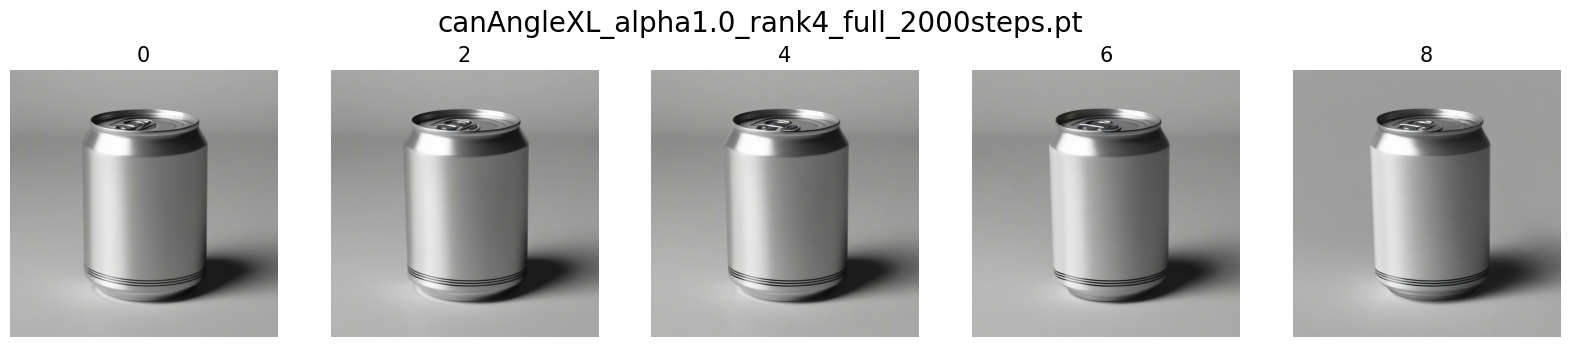

In [9]:
weight_dtype = torch.bfloat16
start_noise = 700
num_images_per_prompt = 1
scales = [0, 2, 4, 6, 8]
for prompt in prompts:
    for _ in range(num_images_per_prompt):
        seed = random.randint(0,2**15)
        print(prompt, seed)
        for lora_weight in lora_weights:
            pipe = StableDiffusionXLPipeline.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0', torch_dtype=weight_dtype)

            # pipe.__call__ = call
            pipe = pipe.to(device)
            unet = pipe.unet
            if 'full' in lora_weight:
                train_method = 'full'
            elif 'noxattn' in lora_weight:
                train_method = 'noxattn'
            else:
                train_method = 'noxattn'

            network_type = "c3lier"
            if train_method == 'xattn':
                network_type = 'lierla'

            modules = DEFAULT_TARGET_REPLACE
            if network_type == "c3lier":
                modules += UNET_TARGET_REPLACE_MODULE_CONV
            import os
            model_name = lora_weight

            name = os.path.basename(model_name)
            rank = 4
            alpha = 1
            if 'rank4' in lora_weight:
                rank = 4
            if 'rank8' in lora_weight:
                rank = 8
            if 'alpha1' in lora_weight:
                alpha = 1.0
            network = LoRANetwork(
                    unet,
                    rank=rank,
                    multiplier=1.0,
                    alpha=alpha,
                    train_method=train_method,
                ).to(device, dtype=weight_dtype)
            network.load_state_dict(torch.load(lora_weight))


            image_list = []
            for scale in scales:
                generator = torch.manual_seed(seed)
                images = pipe(prompt, num_images_per_prompt=1, num_inference_steps=50, generator=generator, network=network, start_noise=start_noise, scale=scale, unet=unet).images[0]
                image_list.append(images)
            del unet, network, pipe
            unet = None
            network = None
            pipe = None
            torch.cuda.empty_cache()
            flush()

            fig, ax = plt.subplots(1, len(image_list), figsize=(20,4))
            for i, a in enumerate(ax):
                a.imshow(image_list[i])
                a.set_title(f"{scales[i]}",fontsize=15)
                a.axis('off')

            plt.suptitle(f'{os.path.basename(lora_weight)}', fontsize=20)
            # plt.tight_layout()
            plt.show()